In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import re
import folium
from folium.plugins import MarkerCluster

# Load the data
path = '/Users/rfd/vigilo-notebooks-bapav/vigilo2024/data_collection'
df_incidents = pd.read_csv(f'{path}/df_incidents.csv')
df_poi = pd.read_csv(f'{path}/df_poi.csv')
df_incidents.head()

,token,latitude,longitude,address,comment,explanation,time,categorie,cityname
0,AA1CA063,43.606022,3.873078,"Cours Gambetta, Montpellier",Roue dans les Rails du tram,La personne venait d’une rue perpendiculaire e...,2024-05-16 11:55:00,9,Montpellier
1,AF00A88E,43.617920,3.882070,"Rue de la Cavalerie, Montpellier",stationnement gênant récurrent,stationnement gênant sur le trottoir systémati...,2024-05-15 19:03:00,2,Montpellier
2,B9B3C9BA,43.596166,3.897689,"Rue des Acconiers, Montpellier",Risque de chute,Poteau anti-stationnement en travers de la piste,2024-05-11 17:32:00,2,Montpellier
3,1441837B,43.598695,3.904834,"Avenue Nina Simone, Montpellier",Road to nowhere,NaN,2024-05-08 15:34:00,3,Montpellier
4,CA159445,43.696450,3.810200,"Rue de Coulondres, Saint-Gély-du-Fesc",Véhicule stationné sur piste cyclable,NaN,2024-05-08 09:29:00,2,Saint-Gély-du-Fesc


In [98]:
df = df_incidents[df_incidents['categorie'] == 8]
df.head()

,token,latitude,longitude,address,comment,explanation,time,categorie,cityname
13,51740784,43.612372,3.870023,"Place Jacques Mirouze, Montpellier",pas de place pour la piscine,NaN,2024-04-16 06:54:00,8,Montpellier
160,C6D5F36E,43.576349,3.928943,", Lattes",manque liaison de 400m entre 2 pistes cyclables,L'avenue Georges Frêche est équipée de 2 belle...,2023-09-20 14:25:00,8,Lattes
163,2F3C8944,43.614624,3.851939,"Rue de Las Sorbes, Montpellier",Circulation très dangereuse des vélos en montée,Vélos en montée obligés de zigzaguer entre les...,2023-09-19 16:49:00,8,Montpellier
223,2E2A429B,43.604093,3.887377,"de barcelone, Montpellier",manque un miroir routier car croisement dangereux,NaN,2023-08-31 17:18:00,8,Montpellier
369,A63C6193,43.658786,3.972549,"Rue de la Cadoule, Vendargues",parking à vélo kiné,NaN,2023-07-07 07:36:09,8,Vendargues


In [99]:
BUFFER_SIZE = 300  # Buffer in meters
#geopy.distance.great_circle((x['coordinates_lat'], x['coordinates_lon']),(df_poi['lat'],df_poi['lon'])).meters < BUFFER_SIZE

# Create a new column with the number of incidents in the buffer
df_poi['incidents_in_buffer'] = df_poi.apply(lambda x: sum([geopy.distance.great_circle((x['latitude'], x['longitude']), (lat, lon)).meters < BUFFER_SIZE for lat, lon in zip(df['latitude'], df['longitude'])]), axis=1)

# Order the dataframe by the number of incidents in the buffer
df_poi = df_poi.sort_values(by='incidents_in_buffer', ascending=False)
df_poi.head()

,Unnamed: 0,name,latitude,longitude,incidents_in_buffer
3,585182991,Crèche collective municipale Les Sept Nains,43.614204,3.879547,11
9,607355557,Crèche municipale Edelweiss,43.603467,3.880709,7
21,1796022006,Les Ateliers d'Arthur,43.612776,3.865531,7
6,595256929,Crèche associative Accroche Cœur,43.617687,3.882115,7
31,4539385901,Halte-garderie L'île aux trésors,43.617402,3.878488,6


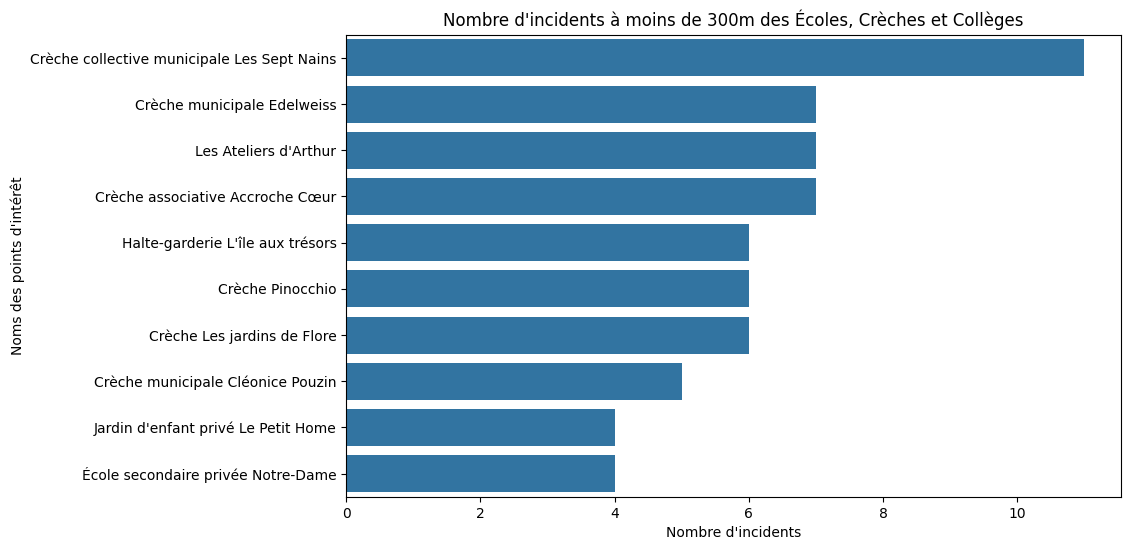

In [100]:
#Plot the number of incidents in the buffer for each POI
plt.figure(figsize=(10, 6))
sns.barplot(x='incidents_in_buffer', y='name', data=df_poi.head(10))
plt.title(f'Nombre d\'incidents à moins de {BUFFER_SIZE}m des Écoles, Crèches et Collèges')
plt.xlabel('Nombre d\'incidents')
plt.ylabel('Noms des points d\'intérêt')
plt.show()


In [102]:
# Mapplot using uMap
# Create a map centered on the coordinates mean of the points of interest
m = folium.Map(location=[df_poi['latitude'].mean(), df_poi['longitude'].mean()], zoom_start=13)

# Create a Marker for points of interest with the ten most incidents in the buffer
for i in range(10):
    folium.Marker([df_poi.iloc[i]['latitude'], df_poi.iloc[i]['longitude']], popup=f"{df_poi.iloc[i]['name']} ({df_poi.iloc[i]['incidents_in_buffer']} incidents)").add_to(m)

# Create a circle for each point of interest with a radius of BUFFER_SIZE
for i in range(10):
    folium.Circle([df_poi.iloc[i]['latitude'], df_poi.iloc[i]['longitude']], radius=BUFFER_SIZE/2, color='red', fill=True, fill_color='red', fill_opacity=0.1).add_to(m)

# Create a different marker for each incident in the buffer
mc = MarkerCluster()
for lat, lon in zip(df['latitude'], df['longitude']):
    mc.add_child(folium.Marker(location=[lat, lon], icon=folium.Icon(color='blue')))
m.add_child(mc)

  

# Display the map
m.save('map.html')
m
